In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import emcee
import os

G = 4.3e-6 # kpc • (km/s)² / M_⊙

In [6]:
def v_plummer(r, M, b):
    return np.sqrt(G * M * r**2 / (r**2 + b**2)**(1.5))

def v_nfw(r, A, r_s):
    r_safe = np.maximum(r, 1e-10)
    r_s_safe = np.maximum(r_s, 1e-10)
    term = (4 * np.pi * G * A) * ((1/r_safe) * np.log(1 + r_safe/r_s_safe) - 1/(r_s_safe + r_safe))
    term = np.maximum(term, 0)
    return np.sqrt(term)

def v_total_model(r, theta):
    """
    Velocidad Total = sqrt(Halo^2 + Disco^2)
    theta: [A, r_s, M_d, b_d]
    """
    A, r_s, M_d, b_d = theta
    
    v_halo = v_nfw(r, A, r_s)
    v_disk = v_plummer(r, M_d, b_d)
    
    return np.sqrt(v_halo**2 + v_disk**2)

In [9]:
def log_prior(theta):
    # Parametros según el modelo (NFW o ISO)
    # Suponiendo ISO: [rho0, r_c, M_d, b_d]
    p1, p2, M_d, b_d = theta 
    
    # 1. Límites Físicos (Hard bounds)
    if not (0 < p1 < 1e11 and 0.1 < p2 < 100 and 0 < M_d < 1e12 and 0.1 < b_d < 20):
        return -np.inf

    # 2. Prior Informativo para el disco (Soft constraints)
    # Forzamos b_d a estar cerca de 2.0 kpc con desviación de 1.0 kpc
    mu_b = 2.0 
    sigma_b = 1.0
    log_prob_b = -0.5 * ((b_d - mu_b) / sigma_b)**2
    
    return log_prob_b

# Calcula qué tan bien ajusta el modelo a los datos (Chi-cuadrado).
def log_likelihood(theta, r, v_obs, v_err):
    # Verificamos primero el prior para no calcular modelos imposibles
    if not np.isfinite(log_prior(theta)):
        return -np.inf

    v_model = v_total_model(r, theta)
    
    # Chi-squared: sum((obs - model)^2 / err^2)
    # Se añade el término log(err^2) para completitud estadística, aunque es cte aquí.
    sigma2 = v_err**2
    return -0.5 * np.sum((v_obs - v_model)**2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_probability(theta, r, v_obs, v_err):
    # Posterior = Prior + Likelihood
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, r, v_obs, v_err)

# Encuentra un punto de partida para MCMC con mínimos cuadrados
def get_starting_guess(r, v_obs, v_err):
    def residuals(theta):
        # Penalización suave si se sale de rangos físicos básicos
        if np.any(theta < 0): return np.inf 
        return (v_obs - v_total_model(r, theta)) / v_err

    # A, r_s, M_d, b_d
    initial_guess = [1e7, 10.0, 1e9, 1.5] 
    bounds = ([0, 0, 0, 0.1], [np.inf, 200, np.inf, 50]) # Limites inferiores y superiores
    
    res = least_squares(residuals, initial_guess, bounds=bounds, loss='soft_l1')
    return res.x

def analizar_galaxia(filename):
    base_filename = os.path.basename(filename) 
    galaxy_name = base_filename.split('_')[0]
    
    data = np.loadtxt(f) # Si falla, prueba pd.read_csv con sep='\s+'
    r = data[:, 0]
    v_obs = data[:, 1]
    v_err = data[:, 2]

    # r, v_obs, v_err = r[mask], v_obs[mask], v_err[mask]

    # B. Punto de partida (Maximum Likelihood Estimation)
    theta_mle = get_starting_guess(r, v_obs, v_err)
    print(f"Punto de partida (Least Squares):")
    print(f"A={theta_mle[0]:.2e}, rs={theta_mle[1]:.2f}, M_d={theta_mle[2]:.2e}, b_d={theta_mle[3]:.2f}")
    
    # C. Configuración MCMC
    ndim = 4  # A, r_s, M_d, b_d
    nwalkers = 32
    nsteps = 8000
    burn_in = 1000 # Pasos a descartar al inicio

    # Inicializar walkers en una bola pequeña alrededor del resultado de Least Squares
    # pos = theta_mle + 1e-4 * theta_mle * np.random.randn(nwalkers, ndim)
    
    # Definimos "a mano" un punto de partida donde r_s sea grande
    # A grande, r_s grande (40 kpc), M_d moderado, b_d normal (5 kpc)
    guess_manual = [5e8, 40.0, 1e10, 5.0] 

    # Inicializar walkers alrededor de este punto
    pos = guess_manual + 1e-2 * np.array(guess_manual) * np.random.randn(nwalkers, ndim)

    # Asegurar que la bola inicial esté dentro de los priors (valores positivos)
    pos = np.abs(pos) 

    # D. Correr MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r, v_obs, v_err))
    
    # print("Corriendo MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=False)

    # E. Resultados y Visualización
    # Aplanar la cadena y descartar burn-in
    flat_samples = sampler.get_chain(discard=burn_in, flat=True)
    
    labels = [r"A", r"r_s", r"M_d", r"b_d"]

    # F. Reporte Numérico
    print("\n--- Resultados Finales (Mediana +/- 1 sigma) ---")
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        print(f"{labels[i]}: {mcmc[1]:.3e} (+{q[1]:.3e} / -{q[0]:.3e})")

    
    # 2. Ajuste vs Datos
    plt.figure(figsize=(6, 4))
    
    r_plot = np.linspace(0.001, max(r), 150)

    # Cálculo error 1-sigma 
    inds = np.random.randint(len(flat_samples), size=200)
    models = np.array([v_total_model(r_plot, sample) for sample in flat_samples[inds]])
    lower = np.percentile(models, 16, axis=0)
    upper = np.percentile(models, 84, axis=0)

    plt.fill_between(r_plot, lower, upper, color='gray', alpha=0.3, label='Error 1-sigma')
    
    # Datos
    plt.errorbar(r, v_obs, yerr=v_err, fmt=".k", capsize=3, label="Datos")
    
    # Mejor ajuste (mediana)
    theta_median = np.median(flat_samples, axis=0)
    plt.plot(r_plot, v_total_model(r_plot, theta_median), "r", lw=2, label="Suma")
    
    # Componentes individuales (usando la mediana)
    plt.plot(r_plot, v_nfw(r_plot, theta_median[0], theta_median[1]), "b--", label="Halo (NFW)")
    plt.plot(r_plot, v_plummer(r_plot, theta_median[2], theta_median[3]), "g:", label="Disco (Plummer)")

    plt.xlabel("Radio [kpc]")
    plt.ylabel("Velocidad [km/s]")
    plt.title(f"Ajuste curva de rotación de {galaxy_name}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    # plt.savefig(f"{filename}_fit.png")
    plt.show()

Punto de partida (Least Squares):
A=1.30e+10, rs=12.77, M_d=5.23e+09, b_d=11.39

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 7.131e+10 (+2.019e+10 / -2.692e+10)
r_s: 4.836e+01 (+1.172e+01 / -1.316e+01)
M_d: 9.988e+09 (+8.450e+09 / -5.558e+09)
b_d: 4.117e+00 (+8.027e-01 / -8.468e-01)


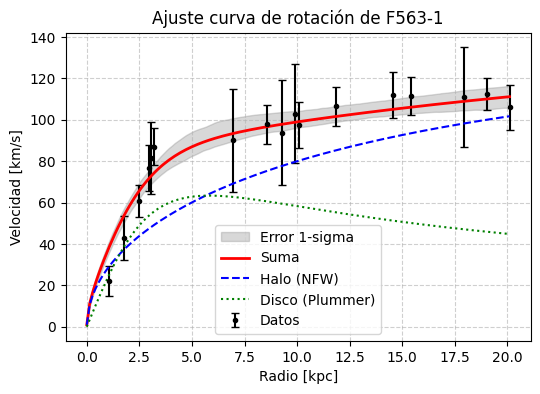

Punto de partida (Least Squares):
A=3.78e+09, rs=6.18, M_d=1.62e+09, b_d=0.93

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 4.463e+10 (+3.632e+10 / -3.143e+10)
r_s: 6.571e+01 (+2.279e+01 / -2.475e+01)
M_d: 2.803e+10 (+6.572e+09 / -7.034e+09)
b_d: 3.941e+00 (+4.516e-01 / -4.180e-01)


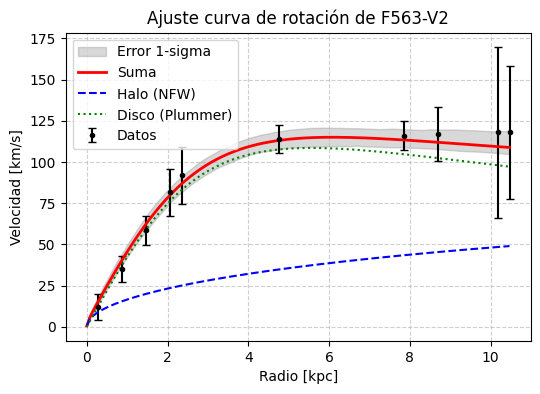

Punto de partida (Least Squares):
A=1.74e+10, rs=13.68, M_d=1.89e+10, b_d=6.82

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 6.558e+10 (+2.430e+10 / -3.466e+10)
r_s: 4.704e+01 (+3.115e+01 / -1.644e+01)
M_d: 3.308e+10 (+1.419e+10 / -2.335e+10)
b_d: 4.880e+00 (+6.029e-01 / -9.629e-01)


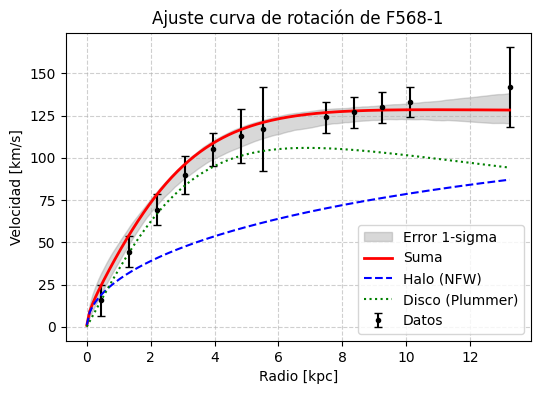

Punto de partida (Least Squares):
A=3.40e+07, rs=0.17, M_d=1.00e+09, b_d=7.72

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 1.936e+10 (+3.149e+10 / -1.508e+10)
r_s: 8.206e+01 (+1.290e+01 / -2.185e+01)
M_d: 4.237e+10 (+6.645e+09 / -7.177e+09)
b_d: 7.594e+00 (+4.254e-01 / -4.261e-01)


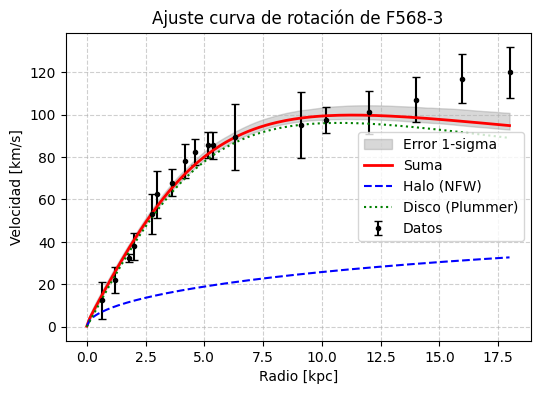

Punto de partida (Least Squares):
A=7.60e+11, rs=200.00, M_d=2.49e+10, b_d=4.43

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 5.876e+10 (+2.805e+10 / -3.161e+10)
r_s: 4.304e+01 (+2.216e+01 / -1.754e+01)
M_d: 1.700e+10 (+9.667e+09 / -8.441e+09)
b_d: 3.814e+00 (+6.734e-01 / -7.769e-01)


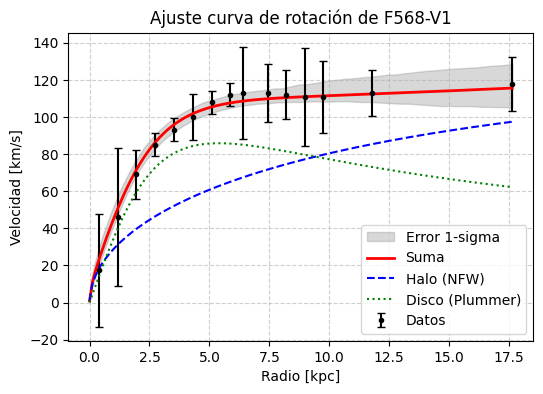

Punto de partida (Least Squares):
A=1.64e+09, rs=2.07, M_d=1.33e+09, b_d=34.43

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 8.617e+10 (+9.866e+09 / -1.690e+10)
r_s: 3.222e+01 (+4.344e+00 / -4.091e+00)
M_d: 7.182e+09 (+1.193e+10 / -6.312e+09)
b_d: 4.682e+00 (+1.099e+00 / -1.470e+00)


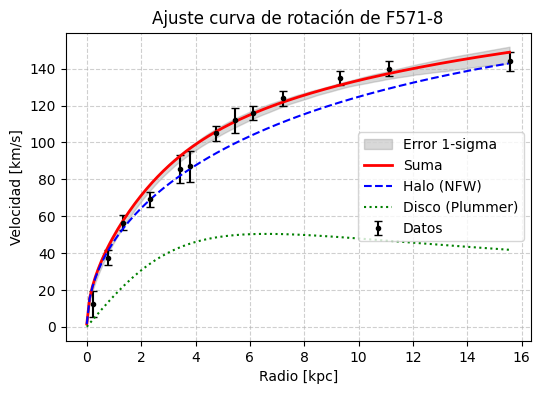

Punto de partida (Least Squares):
A=3.47e+09, rs=5.45, M_d=1.99e+09, b_d=3.96

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 7.192e+10 (+1.985e+10 / -2.874e+10)
r_s: 5.526e+01 (+1.385e+01 / -1.401e+01)
M_d: 1.343e+10 (+5.332e+09 / -4.431e+09)
b_d: 4.522e+00 (+5.053e-01 / -5.333e-01)


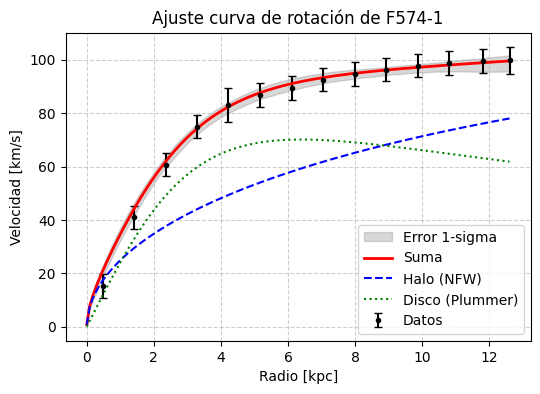

Punto de partida (Least Squares):
A=2.01e+09, rs=2.18, M_d=1.06e+09, b_d=2.82

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 6.107e+10 (+2.722e+10 / -3.329e+10)
r_s: 3.813e+01 (+1.114e+01 / -1.525e+01)
M_d: 9.671e+09 (+4.354e+09 / -3.305e+09)
b_d: 2.264e+00 (+5.017e-01 / -4.582e-01)


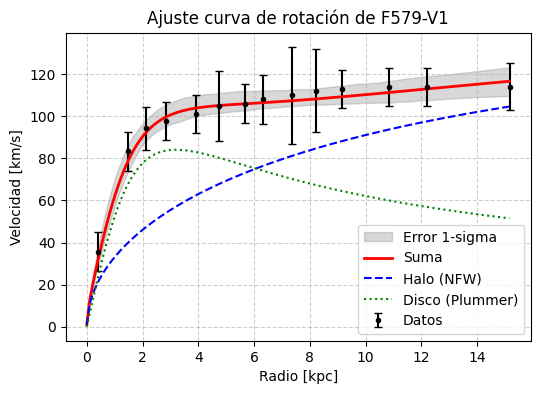

Punto de partida (Least Squares):
A=3.80e+08, rs=1.84, M_d=2.41e+09, b_d=16.11

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 6.300e+10 (+2.466e+10 / -2.918e+10)
r_s: 7.791e+01 (+1.423e+01 / -1.837e+01)
M_d: 1.455e+10 (+4.573e+09 / -4.091e+09)
b_d: 6.008e+00 (+5.408e-01 / -5.547e-01)


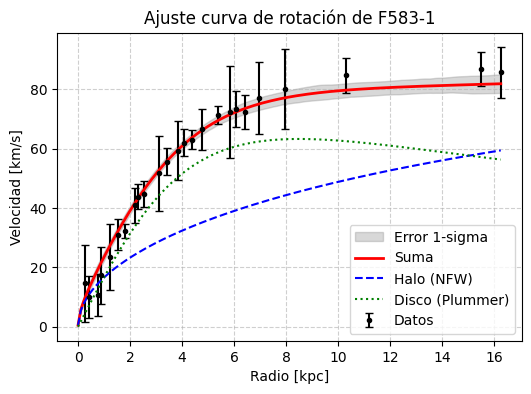

Punto de partida (Least Squares):
A=1.99e+08, rs=0.79, M_d=1.16e+09, b_d=4.25

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 6.334e+10 (+2.565e+10 / -3.114e+10)
r_s: 5.557e+01 (+1.531e+01 / -1.689e+01)
M_d: 1.992e+09 (+2.136e+09 / -1.318e+09)
b_d: 2.754e+00 (+6.757e-01 / -6.926e-01)


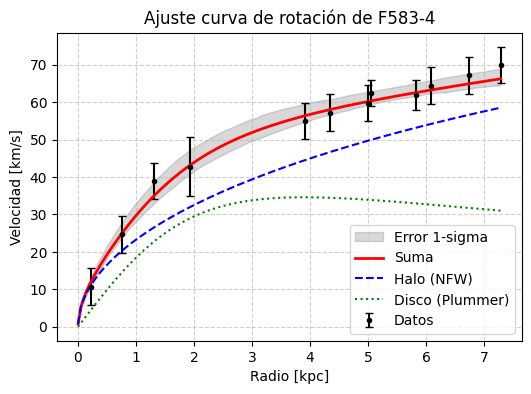

Punto de partida (Least Squares):
A=3.82e+08, rs=4.71, M_d=4.58e+09, b_d=4.98

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 7.134e+10 (+2.009e+10 / -2.750e+10)
r_s: 6.499e+01 (+1.190e+01 / -1.486e+01)
M_d: 7.525e+08 (+1.770e+09 / -6.051e+08)
b_d: 3.281e+00 (+1.061e+00 / -1.026e+00)


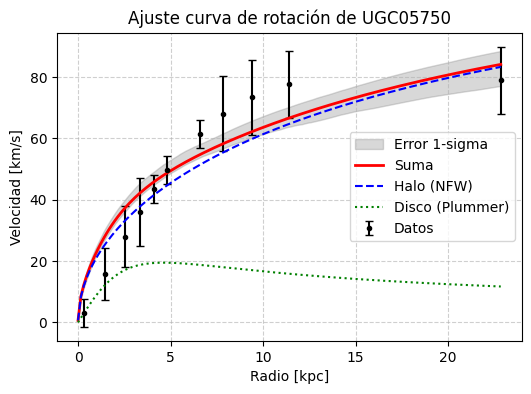

Punto de partida (Least Squares):
A=8.44e+09, rs=3.05, M_d=3.30e+08, b_d=45.47

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 9.100e+10 (+6.464e+09 / -1.166e+10)
r_s: 2.829e+01 (+2.292e+00 / -2.964e+00)
M_d: 2.209e+10 (+5.707e+09 / -5.067e+09)
b_d: 1.251e+00 (+6.718e-01 / -6.303e-01)


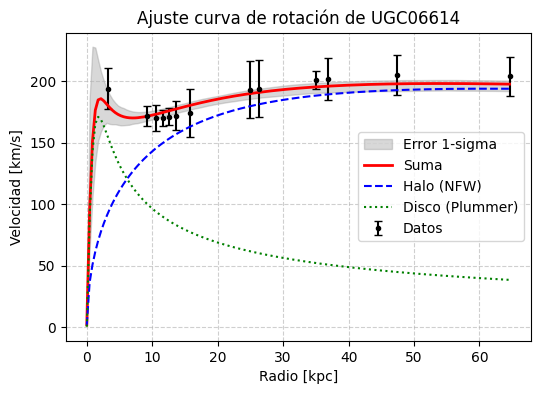

In [10]:
if __name__ == "__main__":
    archivos = [
    'data_lsb/F563-1_rotmod.dat',
    'data_lsb/F563-V2_rotmod.dat',
    'data_lsb/F568-1_rotmod.dat',
    'data_lsb/F568-3_rotmod.dat',
    'data_lsb/F568-V1_rotmod.dat',
    'data_lsb/F571-8_rotmod.dat',
    'data_lsb/F574-1_rotmod.dat',
    'data_lsb/F579-V1_rotmod.dat',
    'data_lsb/F583-1_rotmod.dat',
    'data_lsb/F583-4_rotmod.dat',
    'data_lsb/UGC05750_rotmod.dat',
    'data_lsb/UGC06614_rotmod.dat'
    ]
    
    for f in archivos:
        if os.path.exists(f):
            analizar_galaxia(f)
        else:
            print(f"Archivo {f} no encontrado.")